In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import average_precision_score
import pandas as pd
import numpy as np
from copy import deepcopy
import seaborn as sns
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc
import time
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import sklearn
from copy import deepcopy
from sklearn.model_selection import cross_val_score
import xgboost as xgb
# from xgboost import XGBClassifier, plot_importance
import warnings
warnings.filterwarnings('ignore')

2023-01-26 19:52:38.455266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 19:52:38.509084: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-26 19:52:38.510925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-01-26 19:52:38.510932:

### Loading Data + Visualization

In [2]:
# df = pd.read_csv('./data_collection4/ep1.csv')
# df = pd.read_csv('./data_collection4/paired_errors.csv')
df = pd.read_csv('./robot_data/merged_robot_data.csv')


In [3]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 't', 'x', 'y', 'z', 'rx',
       'ry', 'rz', 'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz',
       'Case'],
      dtype='object')

In [ ]:
df.shape

In [4]:
df = df.drop(['Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0','t'], axis=1)
# df = df.drop(['Unnamed: 0','t'], axis=1)

In [5]:
# df = pd.read_feather('./data_collection4/paired_errors.feather')

In [6]:
df.columns

Index(['x', 'y', 'z', 'rx', 'ry', 'rz', 'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz',
       'Mx', 'My', 'Mz', 'Case'],
      dtype='object')

In [7]:
tot = len(df.Case)
pos = df.Case.sum()
neg = tot-pos
print('Total data: ', tot)
print(f'Label: 0 {neg} | {(neg/tot)*100}%')
print(f'Label: 1 {pos} | {(pos/tot)*100}%')

Total data:  34745
Label: 0 34217 | 98.48035688588286%
Label: 1 528 | 1.5196431141171391%


In [8]:
df.describe()

,x,y,z,rx,ry,rz,vx,vy,vz,Fx,Fy,Fz,Mx,My,Mz
count,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,3.474500e+04,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000
mean,-0.137966,-0.509645,0.072540,-0.000062,-0.000266,0.001135,-0.000007,4.485801e-07,-0.000020,-0.466363,-0.188707,5.003231,-0.002840,-0.014376,0.011366
std,0.002993,0.002702,0.000078,0.001407,0.001430,0.006047,0.001145,1.248120e-03,0.000625,0.844692,1.023472,1.060861,0.108421,0.110534,0.102389
min,-0.144851,-0.515805,0.068121,-0.008628,-0.006530,-0.013364,-0.004638,-5.861016e-03,-0.025025,-3.024711,-6.715337,-0.717291,-0.826048,-0.898659,-0.215748
25%,-0.140047,-0.511618,0.072527,-0.001062,-0.001349,-0.005011,-0.001098,-1.072139e-03,-0.000156,-1.151795,-0.969887,4.606718,-0.086393,-0.099607,-0.047053
50%,-0.137905,-0.509668,0.072543,-0.000021,-0.000186,0.003569,-0.000003,-4.891891e-05,-0.000008,-0.503131,-0.010727,4.985373,0.011002,-0.014019,0.002537
75%,-0.135854,-0.507637,0.072558,0.001097,0.000907,0.006200,0.001057,1.091175e-03,0.000143,0.186419,0.621021,5.389545,0.090412,0.079033,0.109472
max,-0.131514,-0.503526,0.072718,0.002464,0.002585,0.013388,0.003001,5.903866e-03,0.004628,3.948064,2.862133,11.506700,0.201487,0.256065,0.229611


In [6]:
# corr = df.corr()
# plt.figure(figsize=(15,10))
# sns.heatmap(corr,annot=True)
# plt.show()

In [7]:
# corr_with_case = corr['case']
# # delete .abs() if we do not want abs values
# sorted_corr = corr_with_case.abs().sort_values(ascending=False)

# corr_df = pd.DataFrame(sorted_corr)

# # rename the column
# corr_df = corr_df.rename(columns={'case': 'correlation'})

In [8]:
# corr_df

### Data Preprocessing

In [9]:
feature_names = ['Fx', 'Fy', 'Fz', 'Mx', 'My']
# feature_names = ['fx', 'fy', 'fz', 'mx', 'my']

X_df = df[feature_names]
X = X_df.to_numpy()
y = df.Case.to_numpy()

window_len = 100

if window_len:
    n_features = len(feature_names)  # 3

    row = X.shape[0] + 1 - window_len
    col_len = n_features * window_len
    new_x = np.zeros((row, col_len))
    new_y = np.zeros((row, 1))

    for i in range(len(new_x)):
        new_x[i] = X[i:i + window_len].reshape(1, col_len)[0][::-1]
        new_y[i] = y[i + (window_len - 1)]

    y = deepcopy(new_y)
    X = deepcopy(new_x)

total = len(y)
pos = int(y.sum())
neg = total - pos
weight = neg/pos # 13.5

In [10]:
X_df.tail()

,Fx,Fy,Fz,Mx,My
34740,1.054797,-0.624350,6.306035,-0.042642,-0.243759
34741,1.090005,-0.782298,6.756252,-0.053970,-0.214811
34742,1.089035,-0.599375,6.274114,-0.056374,-0.219548
34743,1.105604,-0.601716,5.773809,-0.073985,-0.225064
34744,0.722399,-0.737541,5.655871,-0.064589,-0.212059


In [11]:
X.shape

(34646, 500)

In [12]:
print(f"Total Dataset size: {X.shape}")
print(f"Ratio of 1's in dataset {(pos/total) * 100}% and count is: {pos}")
print(f"Ratio of 0's in dataset {(neg/total) * 100}% and count is: {neg}")

Total Dataset size: (34646, 500)
Ratio of 1's in dataset 1.5239854528661316% and count is: 528
Ratio of 0's in dataset 98.47601454713387% and count is: 34118


### Helper Functions

In [13]:
def plot_prc_and_roc(y_true, y_pred):

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    plt.figure()
    plt.step(recalls, precisions, color='b', alpha=1.0, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.1, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid()

    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
              average_precision))
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
            Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()       


In [14]:
def plot_precision_recall_vs_threshold(y_true, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    f1_vec = 2 * (precisions * recalls) / (precisions + recalls)
    plt.figure()
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.plot(thresholds, f1_vec[:-1], "k-", label='F1')
    plt.xlabel('Threshold')
    plt.title('Precision/ Recall/ F1 Score/ Threshold')
    plt.legend()
    plt.grid()
    plt.show()

In [15]:
def xgb_stratified_kfold_cross_val(X, y, model, print_info):
    """
    StratifiedKFold cross-validation. 
    """
    skf = StratifiedKFold(n_splits=10, shuffle=False)
    aucpr_scores = []
    roc_scores = []
    prec_scores =  []
    recall_scores = []

    for fold_id, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold_id}:")
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if print_info:
            print(f"Ratio of 1's in train set {np.round((y_train.sum())/len(y_train),4) * 100}%")
            print(f"Ratio of 1's in validation set {np.round((y_valid.sum()/len(y_valid)),4) * 100}%")
        
           # fit model
        model.fit(
            X_train,
            y_train,
            early_stopping_rounds=15,
            eval_metric='aucpr', #auc
            eval_set=[(X_valid, y_valid)],
            verbose=False)
        
        y_val_pred = model.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, y_val_pred)
        aucpr = average_precision_score(y_valid, y_val_pred)
        prec = precision_score(y_valid, y_val_pred > 0.5)
        recall = recall_score(y_valid, y_val_pred > 0.5)
        if print_info:
            print('--------------------------------------')
            print(f"Aucpr score for fold {fold_id} is : {aucpr}")
            print(f"ROC score for fold {fold_id} is : {roc}")
            print(f"Precision  : {prec}")
            print(f"Recall : {recall}")
            print('--------------------------------------')

        aucpr_scores.append(aucpr)
        roc_scores.append(roc)
        prec_scores.append(prec)
        recall_scores.append(recall)


    print()
    print(f"Mean across all folds:\nAUCPR: {np.mean(aucpr_scores)}\nROC {np.mean(roc_scores)}\nPrecision: {np.mean(prec_scores)}\nRecall: {np.mean(recall_scores)}")


In [16]:
def get_scores_thresholds(X_test, y_test, model, algo=None):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for thresh in thresholds:
        if algo == "XGB":
            y_pred = model.predict_proba(X_test)[:, 1]
        else:
            y_pred = model.predict(X_test)
            
        print('threshold:', thresh)
        print(confusion_matrix(y_test, y_pred > thresh))
        print(classification_report(y_test, y_pred > thresh))
        print('--------------------------------------')

### XGboost baseline

In [17]:
# clf_xgb = XGBClassifier(max_depth = 8,
#                          learning_rate = 0.005,
#                          n_estimators = 10000,
#                          objective = 'binary:logistic',
#                          gamma = 0.64,
#                          max_delta_step = 3,
#                          min_child_weight = 7,
#                          subsample = 0.7,
#                          colsample_bytree = 0.8,
#                          n_jobs = -1)



# xgb_stratified_kfold_cross_val(X, y, clf_xgb, print_info=False)

### Based on GridSearchCv

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
print('\nAfter split')
print(f"Ratio of 1's in train set {(y_train.sum())/len(y_train) * 100}")
print(f"Ratio of 1's in test set {(y_test.sum()/len(y_test)) * 100}")


After split
Ratio of 1's in train set 1.5225862317794776
Ratio of 1's in test set 1.5295815295815296


#### Using DMatrix
XGBoost provides a way to convert our training and testing data into DMatrix. DMatrix is an optimized data structure that provides better memory efficiency and training speed.

In [19]:
X_train.shape

(27716, 500)

In [20]:
y_train.shape

(27716, 1)

In [21]:
# train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
# test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

In [34]:
clf_xgb = xgb.XGBClassifier(max_depth = 8,
                         learning_rate = 0.005,
                         n_estimators = 1500,
                         objective = 'binary:logistic',
                         gamma = 0.64,
                         subsample = 0.7,
                         colsample_bytree = 0.8,
                         early_stopping_rounds=30,
                         eval_metric='auc',#['aucpr','logloss'], #auc
                         grow_policy='lossguide',
                         n_jobs = -1)




In [35]:
clf_xgb.fit(X_train, 
            y_train,
            # we evaluate on both train and test set
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=1)

[0]	validation_0-auc:0.80061	validation_1-auc:0.76025
[1]	validation_0-auc:0.83088	validation_1-auc:0.77306
[2]	validation_0-auc:0.85677	validation_1-auc:0.80359
[3]	validation_0-auc:0.87858	validation_1-auc:0.82951
[4]	validation_0-auc:0.87823	validation_1-auc:0.83472
[5]	validation_0-auc:0.87926	validation_1-auc:0.84416
[6]	validation_0-auc:0.89833	validation_1-auc:0.85828
[7]	validation_0-auc:0.90100	validation_1-auc:0.86314
[8]	validation_0-auc:0.90085	validation_1-auc:0.86313
[9]	validation_0-auc:0.90109	validation_1-auc:0.86385
[10]	validation_0-auc:0.90044	validation_1-auc:0.86782
[11]	validation_0-auc:0.90024	validation_1-auc:0.86770
[12]	validation_0-auc:0.90211	validation_1-auc:0.86728
[13]	validation_0-auc:0.90205	validation_1-auc:0.87126
[14]	validation_0-auc:0.90274	validation_1-auc:0.87216
[15]	validation_0-auc:0.90253	validation_1-auc:0.87146
[16]	validation_0-auc:0.90223	validation_1-auc:0.88093
[17]	validation_0-auc:0.90212	validation_1-auc:0.88090
[18]	validation_0-au

[149]	validation_0-auc:0.98839	validation_1-auc:0.97119
[150]	validation_0-auc:0.98852	validation_1-auc:0.97125
[151]	validation_0-auc:0.98857	validation_1-auc:0.97118
[152]	validation_0-auc:0.98854	validation_1-auc:0.97115
[153]	validation_0-auc:0.98867	validation_1-auc:0.97111
[154]	validation_0-auc:0.98865	validation_1-auc:0.97111
[155]	validation_0-auc:0.98875	validation_1-auc:0.97087
[156]	validation_0-auc:0.98874	validation_1-auc:0.97089
[157]	validation_0-auc:0.98947	validation_1-auc:0.97070
[158]	validation_0-auc:0.98958	validation_1-auc:0.97144
[159]	validation_0-auc:0.98960	validation_1-auc:0.97230
[160]	validation_0-auc:0.98962	validation_1-auc:0.97242
[161]	validation_0-auc:0.98964	validation_1-auc:0.97240
[162]	validation_0-auc:0.98961	validation_1-auc:0.97240
[163]	validation_0-auc:0.98959	validation_1-auc:0.97244
[164]	validation_0-auc:0.98955	validation_1-auc:0.97241
[165]	validation_0-auc:0.98965	validation_1-auc:0.97273
[166]	validation_0-auc:0.98973	validation_1-auc:

[296]	validation_0-auc:0.99873	validation_1-auc:0.99143
[297]	validation_0-auc:0.99879	validation_1-auc:0.99186
[298]	validation_0-auc:0.99879	validation_1-auc:0.99185
[299]	validation_0-auc:0.99881	validation_1-auc:0.99186
[300]	validation_0-auc:0.99881	validation_1-auc:0.99184
[301]	validation_0-auc:0.99883	validation_1-auc:0.99185
[302]	validation_0-auc:0.99884	validation_1-auc:0.99186
[303]	validation_0-auc:0.99884	validation_1-auc:0.99188
[304]	validation_0-auc:0.99889	validation_1-auc:0.99195
[305]	validation_0-auc:0.99889	validation_1-auc:0.99192
[306]	validation_0-auc:0.99888	validation_1-auc:0.99192
[307]	validation_0-auc:0.99894	validation_1-auc:0.99193
[308]	validation_0-auc:0.99895	validation_1-auc:0.99200
[309]	validation_0-auc:0.99895	validation_1-auc:0.99201
[310]	validation_0-auc:0.99895	validation_1-auc:0.99201
[311]	validation_0-auc:0.99896	validation_1-auc:0.99205
[312]	validation_0-auc:0.99898	validation_1-auc:0.99210
[313]	validation_0-auc:0.99898	validation_1-auc:

[443]	validation_0-auc:0.99972	validation_1-auc:0.99494
[444]	validation_0-auc:0.99972	validation_1-auc:0.99493
[445]	validation_0-auc:0.99972	validation_1-auc:0.99492
[446]	validation_0-auc:0.99972	validation_1-auc:0.99491
[447]	validation_0-auc:0.99972	validation_1-auc:0.99490
[448]	validation_0-auc:0.99972	validation_1-auc:0.99488
[449]	validation_0-auc:0.99972	validation_1-auc:0.99490
[450]	validation_0-auc:0.99972	validation_1-auc:0.99489
[451]	validation_0-auc:0.99972	validation_1-auc:0.99490
[452]	validation_0-auc:0.99972	validation_1-auc:0.99490
[453]	validation_0-auc:0.99972	validation_1-auc:0.99487
[454]	validation_0-auc:0.99971	validation_1-auc:0.99487
[455]	validation_0-auc:0.99971	validation_1-auc:0.99487
[456]	validation_0-auc:0.99971	validation_1-auc:0.99487
[457]	validation_0-auc:0.99974	validation_1-auc:0.99488
[458]	validation_0-auc:0.99974	validation_1-auc:0.99491
[459]	validation_0-auc:0.99974	validation_1-auc:0.99492
[460]	validation_0-auc:0.99974	validation_1-auc:

[590]	validation_0-auc:0.99996	validation_1-auc:0.99737
[591]	validation_0-auc:0.99996	validation_1-auc:0.99737
[592]	validation_0-auc:0.99996	validation_1-auc:0.99737
[593]	validation_0-auc:0.99996	validation_1-auc:0.99736
[594]	validation_0-auc:0.99996	validation_1-auc:0.99736
[595]	validation_0-auc:0.99996	validation_1-auc:0.99737
[596]	validation_0-auc:0.99996	validation_1-auc:0.99738
[597]	validation_0-auc:0.99996	validation_1-auc:0.99737
[598]	validation_0-auc:0.99996	validation_1-auc:0.99736
[599]	validation_0-auc:0.99996	validation_1-auc:0.99737
[600]	validation_0-auc:0.99996	validation_1-auc:0.99737
[601]	validation_0-auc:0.99996	validation_1-auc:0.99737
[602]	validation_0-auc:0.99996	validation_1-auc:0.99737
[603]	validation_0-auc:0.99996	validation_1-auc:0.99737
[604]	validation_0-auc:0.99996	validation_1-auc:0.99736
[605]	validation_0-auc:0.99996	validation_1-auc:0.99741
[606]	validation_0-auc:0.99996	validation_1-auc:0.99739
[607]	validation_0-auc:0.99996	validation_1-auc:

[737]	validation_0-auc:0.99999	validation_1-auc:0.99816
[738]	validation_0-auc:0.99999	validation_1-auc:0.99816
[739]	validation_0-auc:0.99999	validation_1-auc:0.99816
[740]	validation_0-auc:0.99999	validation_1-auc:0.99816
[741]	validation_0-auc:0.99999	validation_1-auc:0.99815
[742]	validation_0-auc:0.99999	validation_1-auc:0.99816
[743]	validation_0-auc:1.00000	validation_1-auc:0.99816
[744]	validation_0-auc:1.00000	validation_1-auc:0.99816
[745]	validation_0-auc:1.00000	validation_1-auc:0.99817
[746]	validation_0-auc:1.00000	validation_1-auc:0.99817
[747]	validation_0-auc:1.00000	validation_1-auc:0.99816
[748]	validation_0-auc:1.00000	validation_1-auc:0.99816
[749]	validation_0-auc:1.00000	validation_1-auc:0.99816
[750]	validation_0-auc:1.00000	validation_1-auc:0.99816
[751]	validation_0-auc:1.00000	validation_1-auc:0.99816
[752]	validation_0-auc:1.00000	validation_1-auc:0.99816
[753]	validation_0-auc:1.00000	validation_1-auc:0.99816
[754]	validation_0-auc:1.00000	validation_1-auc:

[884]	validation_0-auc:1.00000	validation_1-auc:0.99831
[885]	validation_0-auc:1.00000	validation_1-auc:0.99830
[886]	validation_0-auc:1.00000	validation_1-auc:0.99829
[887]	validation_0-auc:1.00000	validation_1-auc:0.99829
[888]	validation_0-auc:1.00000	validation_1-auc:0.99828
[889]	validation_0-auc:1.00000	validation_1-auc:0.99828
[890]	validation_0-auc:1.00000	validation_1-auc:0.99828
[891]	validation_0-auc:1.00000	validation_1-auc:0.99828
[892]	validation_0-auc:1.00000	validation_1-auc:0.99827
[893]	validation_0-auc:1.00000	validation_1-auc:0.99827
[894]	validation_0-auc:1.00000	validation_1-auc:0.99827
[895]	validation_0-auc:1.00000	validation_1-auc:0.99828
[896]	validation_0-auc:1.00000	validation_1-auc:0.99828
[897]	validation_0-auc:1.00000	validation_1-auc:0.99829
[898]	validation_0-auc:1.00000	validation_1-auc:0.99829
[899]	validation_0-auc:1.00000	validation_1-auc:0.99829
[900]	validation_0-auc:1.00000	validation_1-auc:0.99829
[901]	validation_0-auc:1.00000	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.64, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1500, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [36]:
results = clf_xgb.evals_result()

In [41]:
# clf_xgb.save_model("xgboost3.json")

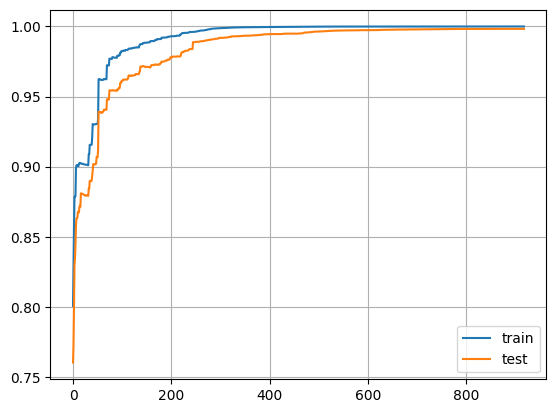

In [38]:
# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
# show the legend
plt.legend()
plt.grid()
plt.show()

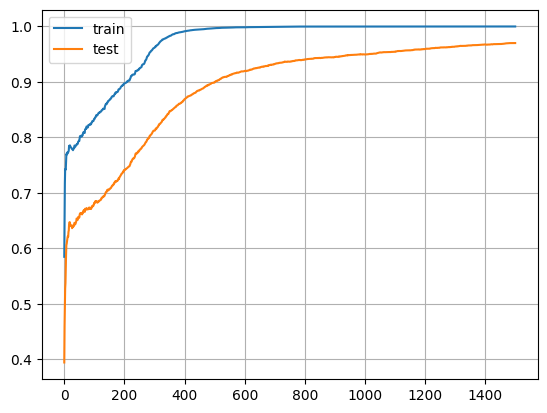

In [27]:
# plot learning curves
plt.plot(results['validation_0']['aucpr'], label='train')
plt.plot(results['validation_1']['aucpr'], label='test')
# show the legend
plt.legend()
plt.grid()
plt.show()

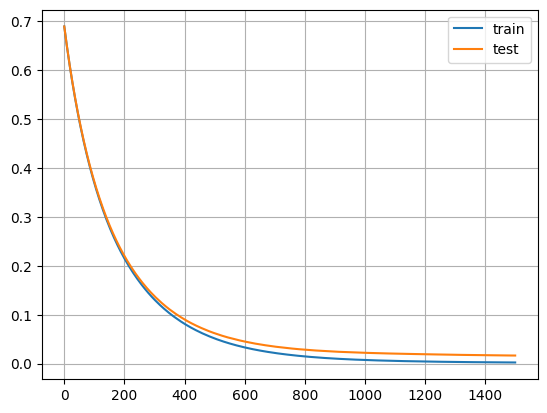

In [28]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
plt.grid()
plt.show()

In [39]:
y_test_pred = clf_xgb.predict_proba(X_test)[:, 1]

In [40]:
print('AUPRC',average_precision_score(y_test, y_test_pred))
print('AUROC',roc_auc_score(y_test, y_test_pred))

print()
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()
print(classification_report(y_test, y_test_pred > 0.5))

AUPRC 0.9443538924428042
AUROC 0.9983244486717247

[[6824    0]
 [  61   45]]

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      6824
         1.0       1.00      0.42      0.60       106

    accuracy                           0.99      6930
   macro avg       1.00      0.71      0.80      6930
weighted avg       0.99      0.99      0.99      6930



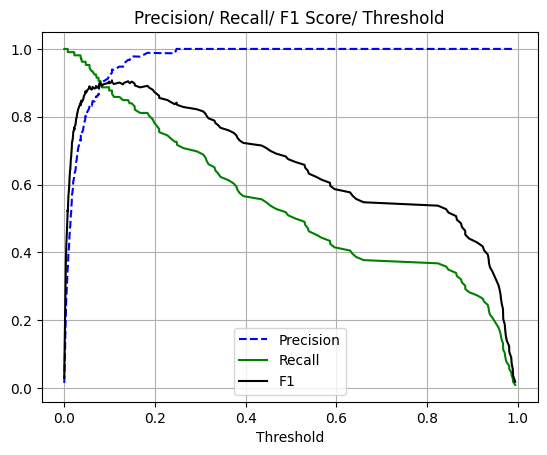

In [31]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

In [32]:
get_scores_thresholds(X_test, y_test, clf_xgb, algo="XGB")

threshold: 0.1
[[6817    7]
 [  13   93]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6824
         1.0       0.93      0.88      0.90       106

    accuracy                           1.00      6930
   macro avg       0.96      0.94      0.95      6930
weighted avg       1.00      1.00      1.00      6930

--------------------------------------
threshold: 0.2
[[6823    1]
 [  24   82]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6824
         1.0       0.99      0.77      0.87       106

    accuracy                           1.00      6930
   macro avg       0.99      0.89      0.93      6930
weighted avg       1.00      1.00      1.00      6930

--------------------------------------
threshold: 0.3
[[6824    0]
 [  33   73]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6824
         1.0       1.00      0.69

In [33]:
X_df.columns

Index(['Fx', 'Fy', 'Fz', 'Mx', 'My'], dtype='object')

In [45]:
# # Plotting feature importance
# clf_xgb.get_booster().feature_names = X_df.columns.tolist()
# importances = clf_xgb.feature_importances_
# xgboost.plot_importance(clf_xgb.get_booster())
# plt.show()

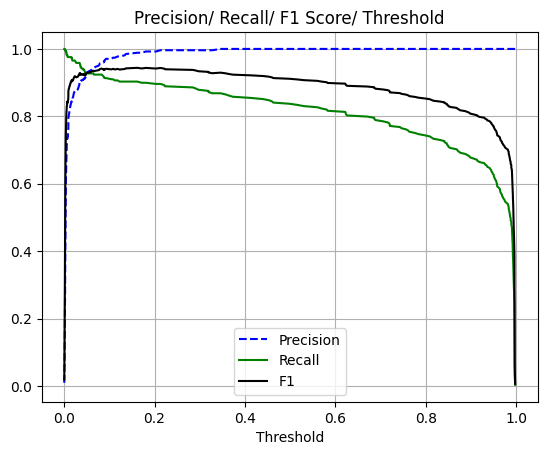

In [46]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

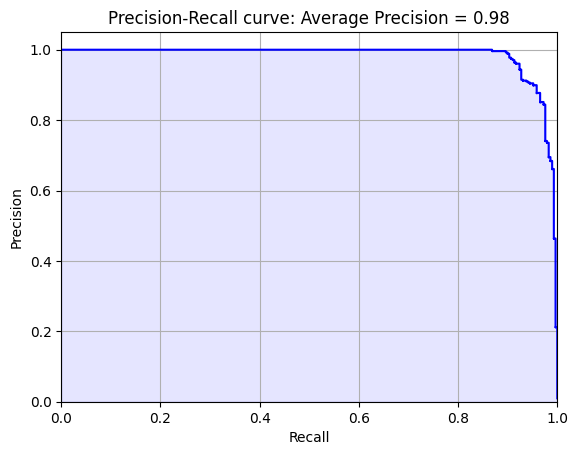

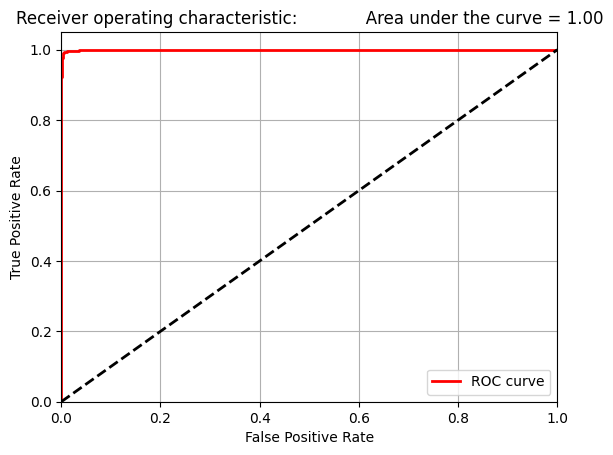

In [47]:
plot_prc_and_roc(y_test, y_test_pred)

In [ ]:
# model.save('test_all_100')

### Re-fit on whole data!

In [ ]:
# n_inputs = X.shape[1]  # (77862, 3)
# print('Input shape',n_inputs)
# model = make_model(n_inputs, metrics=METRICS)

In [ ]:
# EPOCHS=100 #200
# BATCH_SIZE=1024# 2048
# final_history = model.fit(X, y,
#                           epochs=EPOCHS,
#                           batch_size=BATCH_SIZE,
#                           verbose=1,
#                           shuffle=True) 

In [ ]:
# # plot training history
# plt.plot(final_history.history['loss'], label='train')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# model.save('test_all_100_full')